# Checking Hyperparameter Configurations after Hyperparameter Optimization (HPO) - FD001

In [1]:
# importing modules
import pandas as pd
import pygmo as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Importing HPO results (keeping only up to 300 function evaluations)
configs = pd.read_csv('../GRU/Final_experiments/dataset_1/results_no_cv_HO_14_12_MO').iloc[:300]

In [3]:
configs.head()

,rmse_train,mae_train,r2_train,uncertainty_train,rmse_test,mae_test,r2_test,uncertainty_test,net_cfg
0,1.181496e+02,9.547102e+01,-8.401320,0.539599,1.145878e+02,1.008391e+02,-14.996822,0.552505,"{""num_rec"": 1, ""max_time"": 23, ""neuron_0"": 22,..."
1,3.871338e+01,2.933810e+01,0.356078,15.063834,3.744115e+01,3.006062e+01,0.127134,15.859310,"{""num_rec"": 1, ""max_time"": 31, ""neuron_0"": 24,..."
2,4.784384e+01,3.659232e+01,0.118531,5.907845,4.567716e+01,3.656544e+01,-0.127551,5.832887,"{""num_rec"": 1, ""max_time"": 35, ""neuron_0"": 80,..."
3,4.544020e+01,3.409842e+01,0.070034,8.355793,4.167088e+01,3.360285e+01,-0.126457,8.494248,"{""num_rec"": 1, ""max_time"": 27, ""neuron_0"": 95,..."
4,8.396453e+10,1.083317e+09,-0.000166,0.407556,1.066565e+09,1.068397e+08,-0.010136,0.411235,"{""num_rec"": 1, ""max_time"": 21, ""neuron_0"": 52,..."


In [4]:
configs.shape

(300, 9)

In [5]:
# Scaling data to calculate the hypervolume indicator (HVI)
scaler = MinMaxScaler()
norm_cfgs = scaler.fit_transform(configs[['rmse_test', 'uncertainty_test']])

In [6]:
hyper_volume =[]
for i in range(norm_cfgs.shape[0]):
    hv = pg.hypervolume(norm_cfgs[:i+1])
    hyper_volume.append(hv.compute(ref_point=[1.1,1.1]))

hyper_volume = np.array(hyper_volume)

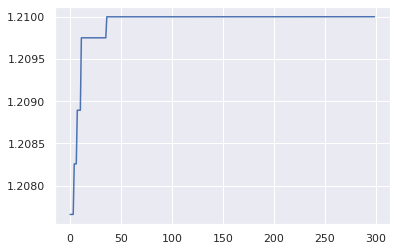

In [7]:
plt.plot(np.arange(hyper_volume.shape[0]), hyper_volume)

In [8]:
# Calculating the Pareto front
pareto_index = pg.non_dominated_front_2d(configs[['rmse_test', 'uncertainty_test']])

In [9]:
pareto_configs = configs.iloc[pareto_index]

In [10]:
pareto_configs

,rmse_train,mae_train,r2_train,uncertainty_train,rmse_test,mae_test,r2_test,uncertainty_test,net_cfg
187,7.456208,5.252828,9.437999e-01,6.201423,8.109570,5.118478,8.949457e-01,5.871751,"{""num_rec"": 2, ""max_time"": 30, ""neuron_0"": 84,..."
263,8.469563,5.409419,9.356169e-01,6.161230,9.267965,5.459378,8.765050e-01,5.855034,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 77,..."
101,12.510084,8.137508,8.328499e-01,4.059068,10.238922,6.424408,8.192457e-01,3.280721,"{""num_rec"": 1, ""max_time"": 24, ""neuron_0"": 72,..."
290,12.795417,8.243829,8.363770e-01,3.656610,10.306455,6.610912,8.294439e-01,2.854231,"{""num_rec"": 1, ""max_time"": 30, ""neuron_0"": 68,..."
267,21.028823,17.815836,4.855338e-01,2.856778,19.362239,16.825543,3.236094e-01,2.271743,"{""num_rec"": 1, ""max_time"": 38, ""neuron_0"": 49,..."
165,40.479117,33.665333,-7.214077e+01,0.424531,34.301178,29.694165,-1.379879e+02,0.357122,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 37,..."
65,41.895494,37.012292,-1.297918e+11,0.000086,37.589225,31.776686,-2.453531e+17,0.000008,"{""num_rec"": 2, ""max_time"": 24, ""neuron_0"": 79,..."


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

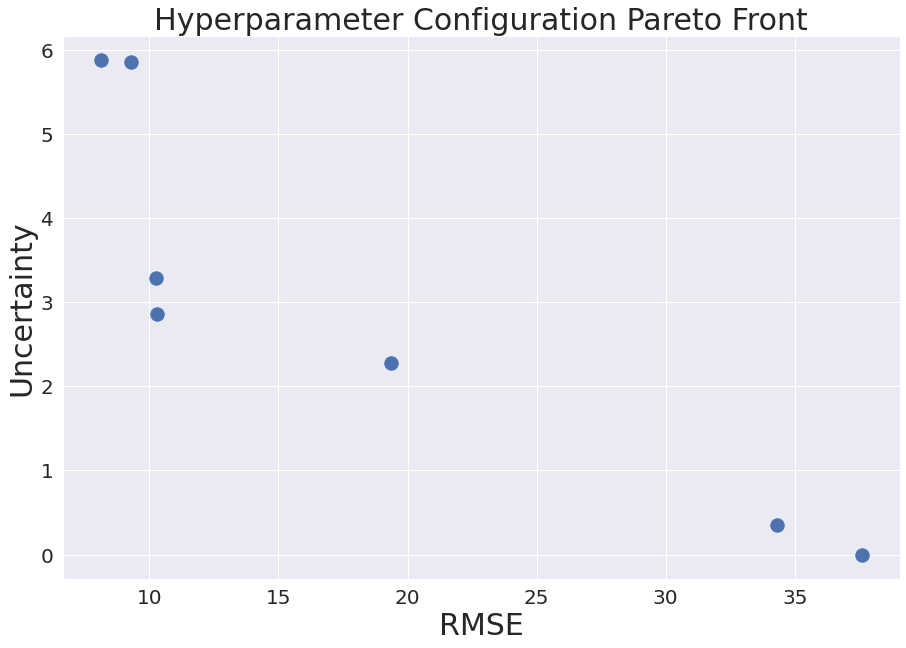

In [11]:
# Ploting the Pareto front of HPO on the validation set

x = pareto_configs['rmse_test'].values
y = pareto_configs['uncertainty_test'].values
plt.figure(figsize=(15,10))
plt.scatter(x, y, s=180)
plt.xlabel('RMSE', fontsize=30)
plt.ylabel('Uncertainty', fontsize=30)
plt.title('Hyperparameter Configuration Pareto Front', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig('./paper_figures/cmapss_1.pdf', format='pdf')


# for i, txt in enumerate(pareto_configs.index):
#     plt.annotate(txt, (x[i], y[i]))

***

# Training full model on the best HP

In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # Running on CPU. Provide list e.g., '1,2' for running on GPUs 1 and 2.

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras import backend as k
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import History
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from RULe.activations import Activate
from RULe.losses import CustomLoss
from RULe.preprocessing import build_data

import numpy as np
import pandas as pd
import math
from datetime import datetime

from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib as mpl

import json

2022-05-20 10:02:54.171073: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [13]:
# Configuration with lowest RMSE on dedicated test

net_cfg = {"num_rec": 1, "max_time": 38, "neuron_0": 49, "neuron_1": 25, "neuron_2": 89, "activation_rec_0": "sigmoid", "activation_rec_1": "tanh", "activation_rec_2": "sigmoid",
 "rec_dropout_norm_0": 0.43733610344927026, "rec_dropout_norm_1": 0.5264641431370682, "rec_dropout_norm_2": 0.39651681655854976, "recurrent_dropout_0": 0.6246405485246954,
  "recurrent_dropout_1": 0.35541873905868654, "recurrent_dropout_2": 0.5826687367719754, "final_activation_0": "softplus", "final_activation_1": "softplus", "percentage": 40,
   "rul": 118, "rul_style": "nonlinear", "lr": "1e-4", "batch": "64", "num_den": 1, "neuron_den_0": 52, "neuron_den_1": 41, "neuron_den_2": 55, "activation_den_0": "tanh",
    "activation_den_1": "sigmoid", "activation_den_2": "tanh", "dropout_0": 0.15695483248610206, "dropout_1": 0.4514125634405938, "dropout_2": 0.6310550702551022}


In [14]:
cfg = {'cv': 10, 'shuffle': True,
'random_state': 21,
'mask_value': -99,
'reps': 30,
'epochs': 20,
'batches': 64}

In [15]:
def load_data():

    np.random.seed(42)

    id_col = 'unit_number'
    time_col = 'time'
    feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in
                                                                       range(1, 22)]
    column_names = [id_col, time_col] + feature_cols

    train_x_orig = pd.read_csv('../DataSets/CMAPSS/train_FD001.csv', header=None, sep='\s+', decimal=".")
    train_x_orig.columns = column_names

    test_x_orig = pd.read_csv('../DataSets/CMAPSS/test_FD001.csv', header=None, sep='\s+', decimal=".")
    test_x_orig.columns = column_names

    test_y_orig = pd.read_csv('../DataSets/CMAPSS/RUL_FD001.csv', header=None, names=['T'])

    # Make engine numbers and days zero-indexed
    train_x_orig.iloc[:, 0:2] -= 1
    test_x_orig.iloc[:, 0:2] -= 1

    # Pre-processing data
    scaler = pipeline.Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(-1, 1))),
        ('remove_constant', VarianceThreshold())])

    train = train_x_orig.copy()
    train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)

    train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=net_cfg['max_time'],
                                    is_test=False, mask_value=cfg['mask_value'],
                                    original_data=None, net_cfg = net_cfg, label=net_cfg['rul_style'])

    test_or = test_x_orig.copy()
    test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


    # Preparing data for the RNN (numpy arrays)
    test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=net_cfg['max_time'],
                                    is_test=True, mask_value=-99,
                                    original_data=np.repeat(200, test_or.shape[0]), net_cfg = net_cfg, label=net_cfg['rul_style'])

    

    return train_x, train_y, test_or, test_y_orig, train_x_orig


In [16]:
train_x, train_y, test_x, test_y, train_x_orig = load_data()


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 12146.14it/s]


In [17]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (20631, 38, 17) train_y (20631, 1) test_x (100, 38, 17) test_y (100, 1)


In [18]:
# Loading saved model trained on the entire dataset with the previously loaded configurations
model = tf.keras.models.load_model('../GRU/Final_experiments/dataset_1/267/saved_models_4_1/cp-0100.ckpt', custom_objects={"CustomLoss": CustomLoss, "Activate": Activate})

2022-05-20 10:03:03.525145: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-20 10:03:03.945385: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-20 10:03:03.945428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neocortex
2022-05-20 10:03:03.945437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neocortex
2022-05-20 10:03:03.945547: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.42.1
2022-05-20 10:03:03.945579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.42.1
2022-05-20 10:03:03.945586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.42.1
2022-05-20 10:03:03.946158: I tensorflow/core/platform/cpu_featu

In [19]:
model.summary()

Model: "weibull_params"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 38, 17)]          0         
_________________________________________________________________
masking (Masking)            (None, 38, 17)            0         
_________________________________________________________________
gru (GRU)                    (None, 49)                9996      
_________________________________________________________________
dense (Dense)                (None, 2)                 100       
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 10,096
Trainable params: 10,096
Non-trainable params: 0
_________________________________________________________________


***

#### MC-Dropout Passes to gather multiple alphas and betas (needed for later)

In [21]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [22]:
reps = 30
test_predict_1 = []
test_predict_2 = []
for i in range(cfg["reps"]):
    tf.random.set_seed(i)
    test_predict = model(test_x, training=True).numpy()
    test_predict_1.append(
        test_predict[:, 0].reshape(test_predict[:, 0].shape[0], 1)
    )
    test_predict_2.append(
        test_predict[:, 1].reshape(test_predict[:, 1].shape[0], 1)
    )

test_predict_1_median = np.median(np.hstack(test_predict_1), axis=1)
test_predict_2_median = np.median(np.hstack(test_predict_2), axis=1)
test_predict_1_median = test_predict_1_median.reshape(
    test_predict_1_median.shape[0], 1
)
test_predict_2_median = test_predict_2_median.reshape(
    test_predict_2_median.shape[0], 1
)
test_predict_1_std = np.std(np.hstack(test_predict_1), axis=1)
test_predict_2_std = np.std(np.hstack(test_predict_2), axis=1)
test_predict_1_std = test_predict_1_std.reshape(test_predict_1_std.shape[0], 1)
test_predict_2_std = test_predict_2_std.reshape(test_predict_2_std.shape[0], 1)

test_predict = np.hstack(
    [
        test_predict_1_median,
        test_predict_2_median,
        test_predict_1_std,
        test_predict_2_std,
    ]
)

test_predict = np.resize(
    test_predict, (test_x.shape[0], 4)
)  # changed from 2 to 4
test_result = np.concatenate((test_y, test_predict), axis=1)
test_results_df = pd.DataFrame(
    test_result,
    columns=["T", "median_alpha", "median_beta", "std_alpha", "std_beta"],
)

test_results_df["predicted_mu"] = test_results_df[
    ["median_alpha", "median_beta"]
].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df["uncertainty"] = np.mean(test_predict[:, 2:], axis=1)

In [23]:
train_predict_1 = []
train_predict_2 = []

success = True

for i in range(cfg["reps"]):
    tf.random.set_seed(i)
    train_predict = model(train_x, training=True).numpy()
    train_predict_1.append(
        train_predict[:, 0].reshape(train_predict[:, 0].shape[0], 1)
    )
    train_predict_2.append(
        train_predict[:, 1].reshape(train_predict[:, 1].shape[0], 1)
    )

train_predict_1_median = np.median(np.hstack(train_predict_1), axis=1)
train_predict_2_median = np.median(np.hstack(train_predict_2), axis=1)
train_predict_1_median = train_predict_1_median.reshape(
    train_predict_1_median.shape[0], 1
)
train_predict_2_median = train_predict_2_median.reshape(
    train_predict_2_median.shape[0], 1
)
train_predict_1_std = np.std(np.hstack(train_predict_1), axis=1)
train_predict_2_std = np.std(np.hstack(train_predict_2), axis=1)
train_predict_1_std = train_predict_1_std.reshape(
    train_predict_1_std.shape[0], 1
)
train_predict_2_std = train_predict_2_std.reshape(
    train_predict_2_std.shape[0], 1
)

train_predict = np.hstack(
    [
        train_predict_1_median,
        train_predict_2_median,
        train_predict_1_std,
        train_predict_2_std,
    ]
)

train_predict = np.resize(train_predict, (train_x.shape[0], 4))
train_result = np.concatenate((train_y, train_predict), axis=1)
train_results_df = pd.DataFrame(
    train_result,
    columns=["T", "median_alpha", "median_beta", "std_alpha", "std_beta"],
)
train_results_df["unit_number"] = train_x_orig["unit_number"].to_numpy()
train_results_df["time"] = train_x_orig["time"].to_numpy()

train_results_df["predicted_mu"] = train_results_df[
    ["median_alpha", "median_beta"]
].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df["uncertainty"] = np.mean(train_predict[:, 2:], axis=1)

***

In [24]:
# Loading results on dedicated test set.
# Models have been trained on the entirety of the training data with the configurations of the Pareto front.
# The results have been saved in the file that is loaded below.
Results = pd.read_csv('../GRU/Final_experiments/dataset_1/Results')

In [25]:
Results

,rmse_train,mae_train,r2_train,uncertainty_train,rmse_test,mae_test,r2_test,uncertainty_test,net_cfg
0,7.089823,4.827719,0.951141,6.086137,20.734014,16.911902,0.635591,6.347113,"{""num_rec"": 2, ""max_time"": 30, ""neuron_0"": 84,..."
1,7.625503,4.684950,0.949609,6.977883,24.847671,20.523445,0.543277,8.512672,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 77,..."
2,12.279424,7.842011,0.841450,4.916361,26.824422,21.366423,0.314110,5.687934,"{""num_rec"": 1, ""max_time"": 24, ""neuron_0"": 72,..."
3,12.530787,7.848395,0.845866,4.207865,29.815131,23.915410,0.174613,4.906784,"{""num_rec"": 1, ""max_time"": 30, ""neuron_0"": 68,..."
4,18.283595,13.910402,0.711747,4.371925,20.790263,15.474533,0.636539,4.883142,"{""num_rec"": 1, ""max_time"": 38, ""neuron_0"": 49,..."
5,14.850582,10.765737,0.804497,6.377253,23.777367,18.717816,0.526813,7.591391,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 37,..."
6,25.633999,20.809390,0.415993,7.046897,23.775796,18.297404,0.524526,7.838632,"{""num_rec"": 2, ""max_time"": 24, ""neuron_0"": 79,..."


Combining the Results with the Pareto front.

In [26]:
pareto_configs.reset_index(drop=True, inplace=True)

In [27]:
Results['rank'] = pareto_configs.index

In [28]:
Results

,rmse_train,mae_train,r2_train,uncertainty_train,rmse_test,mae_test,r2_test,uncertainty_test,net_cfg,rank
0,7.089823,4.827719,0.951141,6.086137,20.734014,16.911902,0.635591,6.347113,"{""num_rec"": 2, ""max_time"": 30, ""neuron_0"": 84,...",0
1,7.625503,4.684950,0.949609,6.977883,24.847671,20.523445,0.543277,8.512672,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 77,...",1
2,12.279424,7.842011,0.841450,4.916361,26.824422,21.366423,0.314110,5.687934,"{""num_rec"": 1, ""max_time"": 24, ""neuron_0"": 72,...",2
3,12.530787,7.848395,0.845866,4.207865,29.815131,23.915410,0.174613,4.906784,"{""num_rec"": 1, ""max_time"": 30, ""neuron_0"": 68,...",3
4,18.283595,13.910402,0.711747,4.371925,20.790263,15.474533,0.636539,4.883142,"{""num_rec"": 1, ""max_time"": 38, ""neuron_0"": 49,...",4
5,14.850582,10.765737,0.804497,6.377253,23.777367,18.717816,0.526813,7.591391,"{""num_rec"": 2, ""max_time"": 38, ""neuron_0"": 37,...",5
6,25.633999,20.809390,0.415993,7.046897,23.775796,18.297404,0.524526,7.838632,"{""num_rec"": 2, ""max_time"": 24, ""neuron_0"": 79,...",6


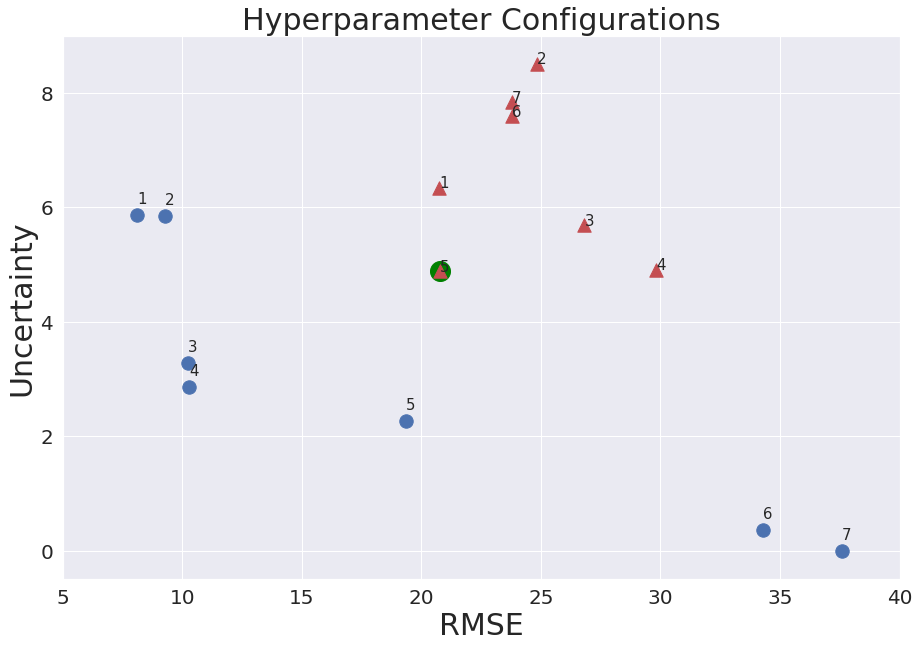

In [29]:
x = Results['rmse_test'].values
y = Results['uncertainty_test'].values
x_prime = pareto_configs['rmse_test'].values
y_prime = pareto_configs['uncertainty_test'].values
plt.figure(figsize=(15,10))
plt.scatter(x[4], y[4], s=400, facecolors='green')
plt.scatter(x, y, marker='^',s=180, c='r')
plt.scatter(x_prime, y_prime,s=180)
plt.xlabel('RMSE', fontsize=30)
plt.ylabel('Uncertainty', fontsize=30)
plt.title('Hyperparameter Configurations', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(5,40)
plt.ylim(-0.5,9)

for i, txt in enumerate(Results['rank']):
    plt.annotate(txt+1, (x[i], y[i]), fontsize=15)

for i, txt in enumerate(pareto_configs.index):
    plt.annotate(txt+1, (x_prime[i], y_prime[i]+0.2), fontsize=15)

# plt.savefig('./paper_figures/cmapss_1_obj_space_annotated.pdf', format='pdf')


***

### Weibull PDFs

#### defining functions

In [30]:
def surv(alpha, beta, t):
    return np.exp(-np.power(t/alpha, beta))

In [31]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [32]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [33]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [34]:
def weibull_mode(alpha, beta):
    # assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

In [35]:
def weibull_variance(alpha, beta):
    var = alpha**2*(math.gamma(1+2/beta)-math.gamma(1+1/beta)**2)
    return var

In [36]:
def plot_weibull_variance(results_df):

    plt.figure(figsize=(30,20))
    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
            alpha=row[1]['mean_alpha']
            beta = row[1]['mean_beta']
            color = color_dict[i]
            variance = weibull_variance(alpha, beta)

            plt.scatter(i, variance, color=color)
            plt.text(i, variance+0.5, i*5)
            plt.title('Weibull distributions variance')

In [37]:
def plot_weibull_predictions(results_df, u):

    fig, ax = plt.subplots(figsize=(30,20))

    t=np.arange(0,150)

    c = np.arange(1, results_df.shape[0] + 1)
    palette = mpl.cm.get_cmap('RdBu_r', results_df.shape[0])
    dummie_cax = ax.scatter(c, c, c=c, cmap=palette)
    ax.cla()

    for i, row in enumerate(results_df.iterrows()):
            alpha=row[1]['median_alpha']
            beta = row[1]['median_beta']
            pos = ax.plot(t, weibull_pdf(alpha, beta, t), c=palette(i), linewidth=2)  # label=label

            ax.set_title('Evolution of RUL distributions (unit='+str(u+1)+')', fontsize=60)
            ax.set_xlabel('Time', fontsize=60)
            ax.set_xlim(150,0)
            ax.set_ylabel('Probability of Failure', fontsize=60)
            ax.tick_params(labelsize=50)

    cbar = fig.colorbar(dummie_cax)
    cbar.ax.tick_params(labelsize=50)
    cbar.set_label('Data time-index', rotation=270, fontsize=50, labelpad=50, y=0.50)

    

#     plt.savefig('./paper_figures/cmapss_1_WB_REVISED_all_time_steps.pdf', format='pdf')
    plt.show()


In [38]:
u = 1  # counting starts from 0!
s = train_results_df[train_results_df.unit_number==u]
s.shape

(287, 9)

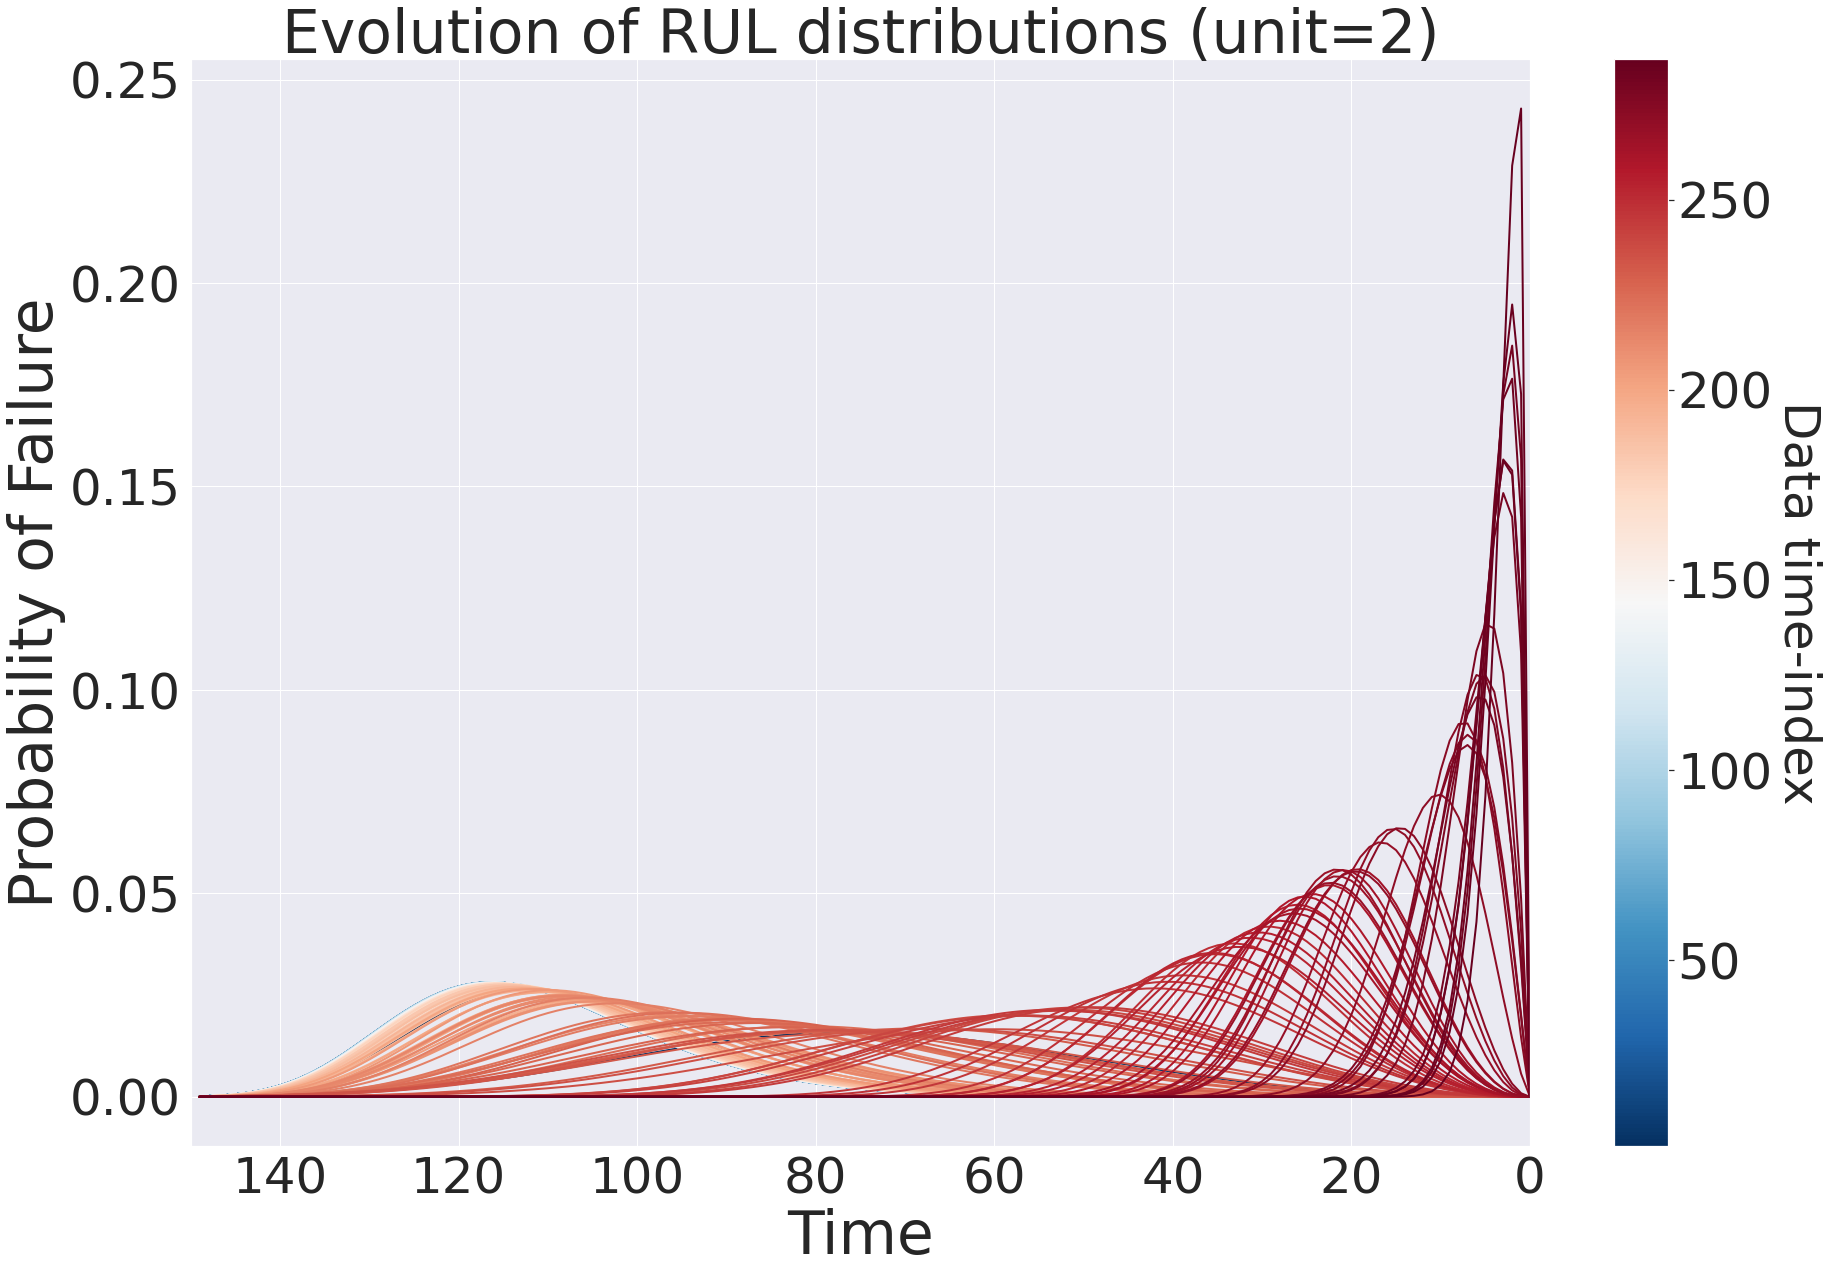

In [39]:
plot_weibull_predictions(s, u)

***

### Application (for paper) - Survival Curves

In [40]:
survs = pd.DataFrame()

a,c = 80,3


A = np.hstack(test_predict_1)
B = np.hstack(test_predict_2)

t=np.arange(0,150)

median_alpha, median_beta, std_alpha, std_beta = test_results_df.iloc[a][['median_alpha', 'median_beta', 'std_alpha', 'std_beta']]

for i in range(30):
    survs['Weibull_'+str(i)] = surv(A[a, i], B[a, i], t)
survs['median'] = surv(median_alpha, median_beta, t)

survs2 = pd.DataFrame()

median_alpha, median_beta, std_alpha, std_beta = test_results_df.iloc[c][['median_alpha', 'median_beta', 'std_alpha', 'std_beta']]

for i in range(30):
    survs2['Weibull_'+str(i)] = surv(A[c, i], B[c, i], t)
survs2['median'] = surv(median_alpha, median_beta, t)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

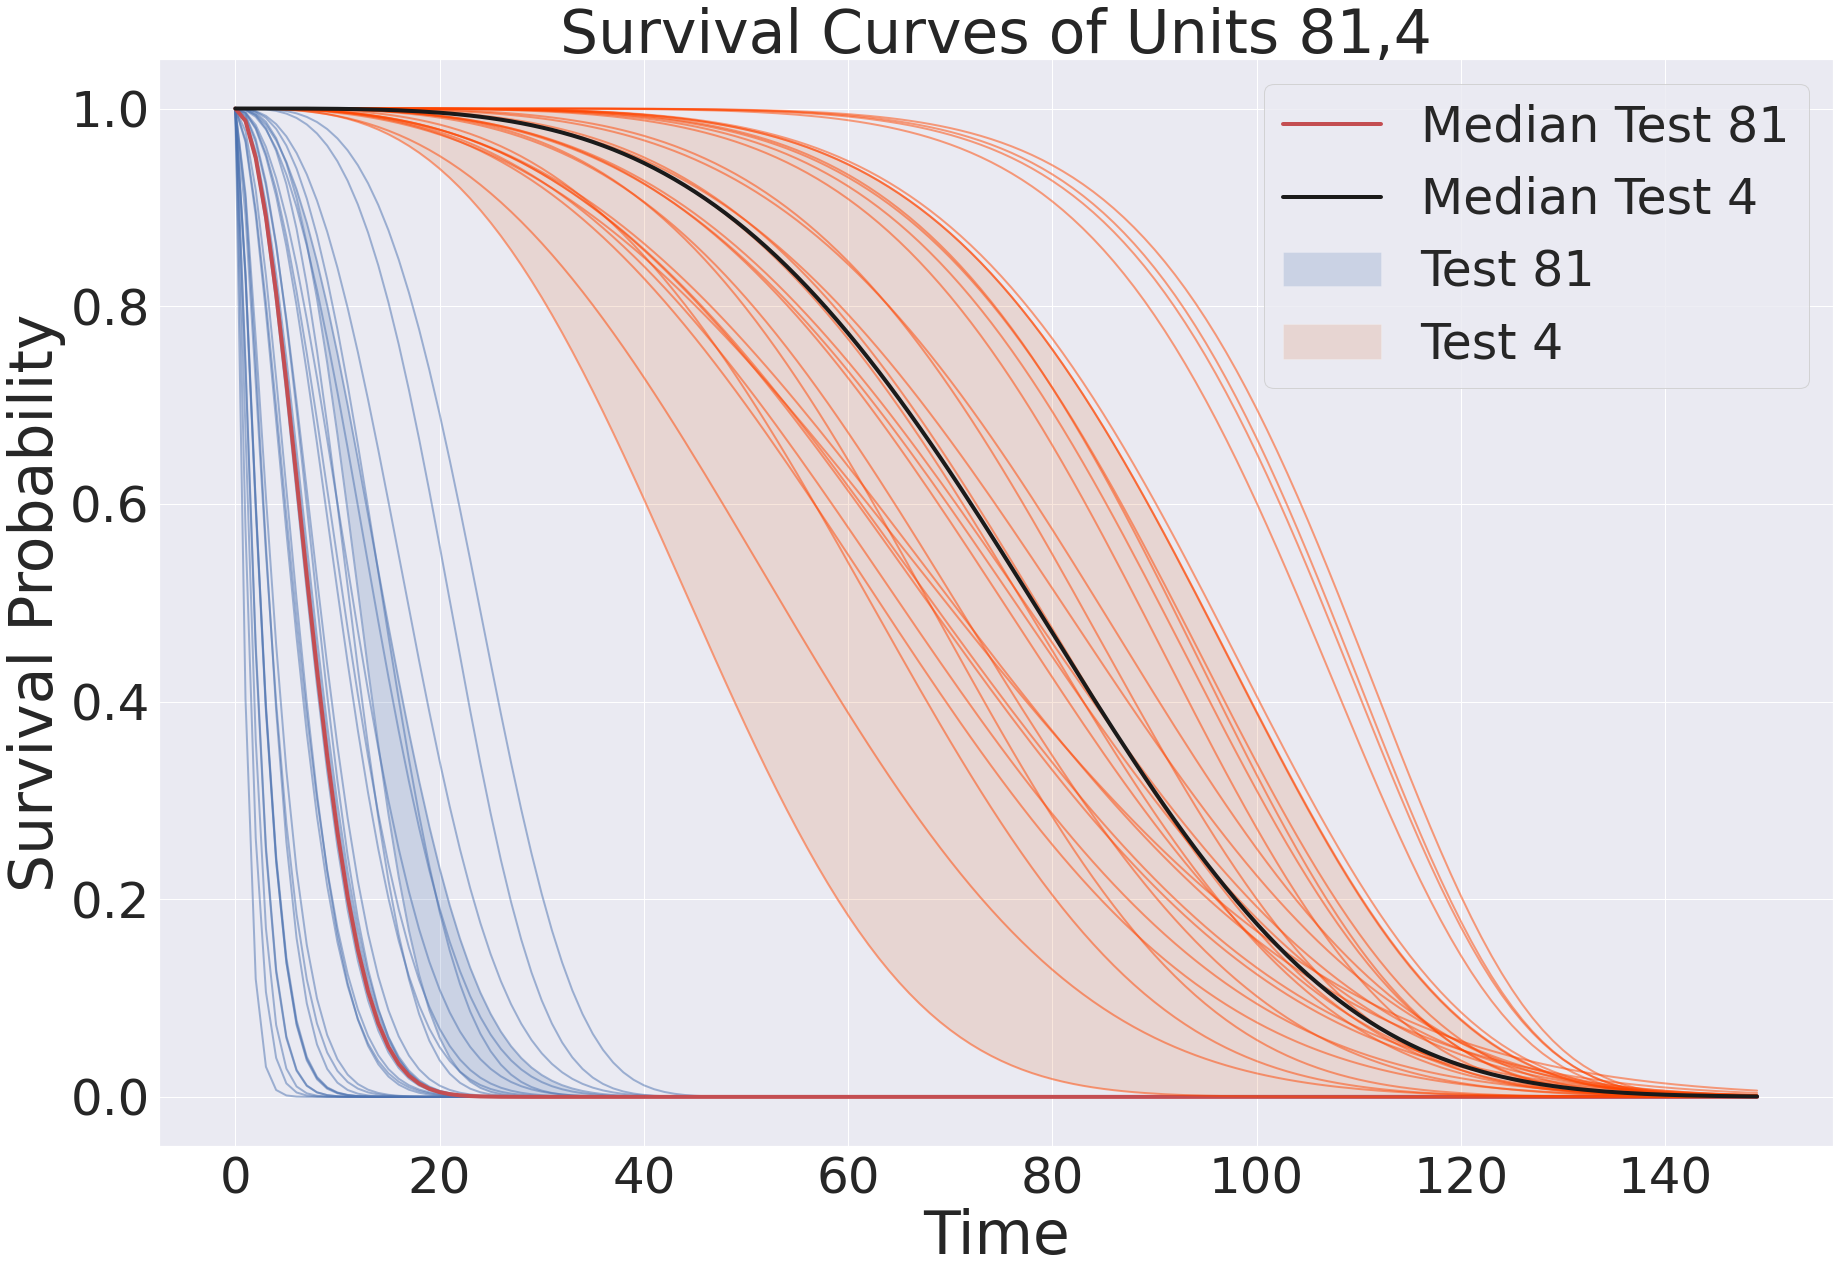

In [41]:
plt.subplots(figsize=(30, 20))

for i in range(30):
    plt.plot(t, survs['Weibull_'+str(i)], color='b', alpha=0.5, linewidth=2)

plt.plot(t, survs['median'], color='r', linewidth=4, label= 'Median Test '+str(a+1))
plt.fill_between(t, survs['Weibull_20'], survs['Weibull_14'], alpha=0.2, label= 'Test '+str(a+1))

for i in range(30):
    plt.plot(t, survs2['Weibull_'+str(i)], color = 'orangered', alpha=0.5, linewidth=2)

plt.plot(t, survs2['median'], color='k', linewidth=4, label= 'Median Test '+str(c+1))
plt.fill_between(t, survs2['Weibull_22'], survs2['Weibull_23'], alpha=0.2, label= 'Test '+str(c+1))

plt.legend(prop={'size': 49})

plt.title(f'Survival Curves of Units {a+1},{c+1}', fontsize=60)
plt.xlabel('Time', fontsize=60)
plt.ylabel('Survival Probability', fontsize=60)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

# plt.savefig('./paper_figures/cmapss_1_SC_median_corrected_shaded_no_CI.pdf', format='pdf')
